<a href="https://colab.research.google.com/github/CIS-522/course-content/blob/main/tutorials/W04_Optimization/W4Tutorial2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CIS-522 Week 4 Part 2
# Optimization

__Instructor__: Lyle Ungar

__Content creator:__ Rongguang Wang

__Content reviewer:__ Pooja Consul, Ann-Katrin Reuel, Kausik Sivakumar

---
# Objectives for today

We show how gradient descent can be tweaked using adaptive learning rate, and other techiniques to really speed up the optimization process, and hint at the theory behind it.

1.   Why use adaptive learning rates?
2.   Why does Adagrad help?
3.   Understand and use RMSprop and Adam
4.   The intuition behind natural gradients
5.   Recognize and mitigate amplification and class error disparities  

In [ ]:
#@markdown What is your Pennkey and pod? (text, not numbers, e.g. bfranklin)
my_pennkey = '' #@param {type:"string"}
my_pod = 'Select' #@param ['Select', 'upain', 'ah-damn-optimizer', 'backpropagandists', 'backpropers','excel-erators','GAN-gsters','han-not-solo','hufflefluffs','lets-taco-bout-it','natural-networkers','pytorture','sigmoids','strong-signals','the-denominators','the-travellers', 'the-weekenders', 'tomorrows-incredibles', 'brute-force']
my_email = '' #@param {type:"string"}
tutorial = 'W4D2'


# start timing
import time
try:t0;
except NameError: t0 = time.time()

---
# Setup
Note that some of the code for today can take up to an hour to run. We have therefore "hidden" that code and shown the resulting outputs.

In [ ]:
# imports
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset
import time
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

import requests
import io
from urllib.request import urlopen

In [ ]:
# @title Figure Settings
import ipywidgets as widgets
%matplotlib inline 
fig_w, fig_h = (8, 6)
plt.rcParams.update({'figure.figsize': (fig_w, fig_h)})
%config InlineBackend.figure_format = 'retina'
SMALL_SIZE = 12


plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/"
              "course-content/master/nma.mplstyle")

# plt.rcParams.update(plt.rcParamsDefault)
# plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
# plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
# plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
# plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
# plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
# plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
# plt.rc('figure', titlesize=SMALL_SIZE)  # fontsize of the figure title

---
# Section 1:  Learning rate scheduling

Video available at https://youtube.com/watch?v=aUmlgb38ABY


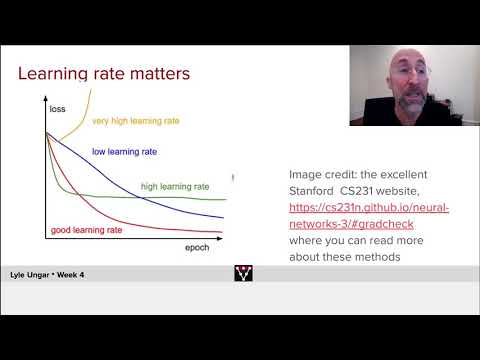

In [ ]:
#@title Video: The importance of the Learning Rate

import time
try: t0;
except NameError: t0=time.time()

from IPython.display import YouTubeVideo
video = YouTubeVideo(id="aUmlgb38ABY", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)
video

If the learning rate is too large, optimization diverges; if it is too small, it takes too long to train or we end up with a suboptimal result. People often start with a large learning rate and then 'decay' or 'anneal' (decrease) it.  This can help both optimization and generalization.

Common beliefs in how annealing works come from the optimization analysis of stochastic gradient descent: 

1.   An initial large learning rate accelerates training or helps the network escape spurious local minima
2.   Decaying the learning rate helps the network converge to a local minimum and avoid oscillation. 

The simplest learning rate schedule is to decrease the learning rate linearly from a large initial value to a small value. This allows large weight changes in the beginning of the learning process and small changes or fine-tuning towards the end of the learning process. There are other schedules such as square root and exponential decay. 


## Exercise 1: Compare different annealing schedules: constant, linear, sqrt(t) and exp(-t)


Firstly, let's plot the simulation of different annealing scheduels: constant, linear, sqrt(t) and exp(-t) in below cell.

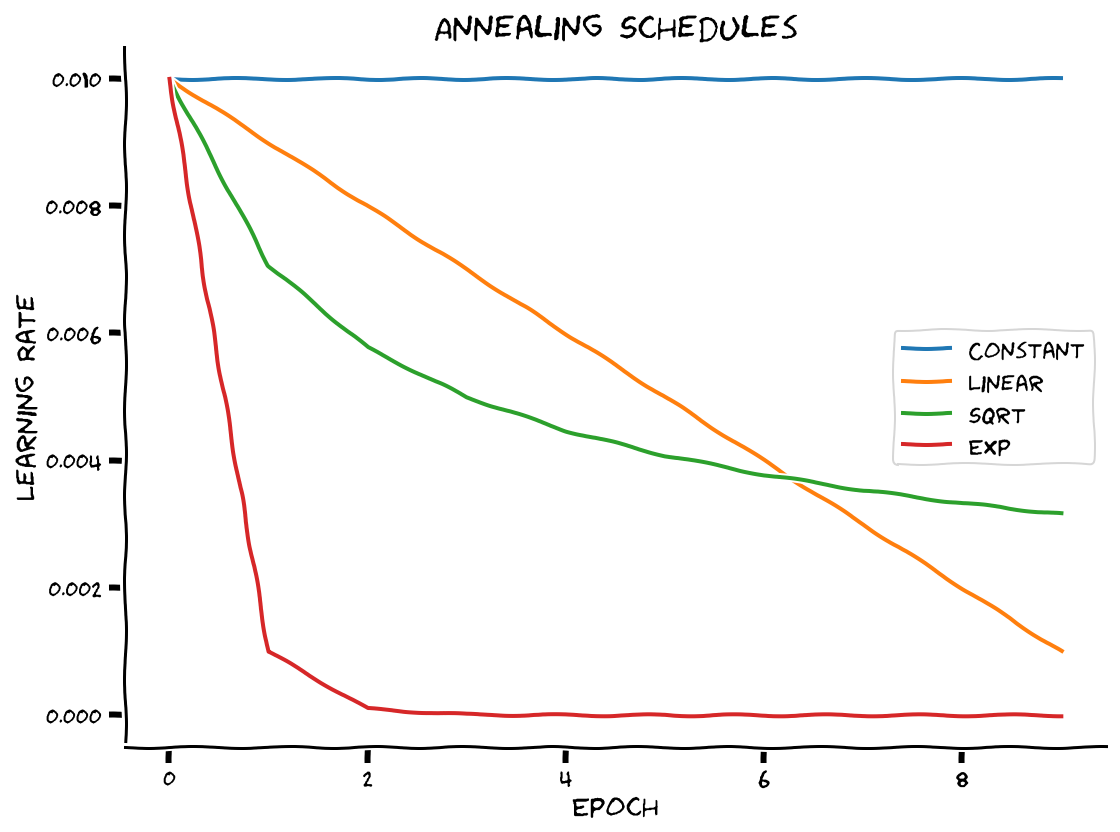

In [ ]:
model = torch.nn.Linear(2, 1)
lr_anneal = ['constant', 'linear', 'sqrt', 'exp']
lr_dict = defaultdict(list)

for idx in range(len(lr_anneal)):
    optimizer = optim.SGD(model.parameters(), lr=1e-2)
    if lr_anneal[idx] == 'constant':
        lambda1 = lambda epoch: 1
    elif lr_anneal[idx] == 'linear':
        lambda1 = lambda epoch: max(1e-7, 1 - 0.1*epoch)
    elif lr_anneal[idx] == 'sqrt':
        lambda1 = lambda epoch: (epoch + 1.0) ** -0.5
    elif lr_anneal[idx] == 'exp':
        lambda1 = lambda epoch: 0.1 ** epoch
    scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)
    for i in range(10):
        optimizer.step()
        lr_dict[lr_anneal[idx]].append(optimizer.param_groups[0]["lr"])
        scheduler.step()

with plt.xkcd():
  plt.plot(range(10), lr_dict['constant'], label='Constant')
  plt.plot(range(10), lr_dict['linear'], label='Linear')
  plt.plot(range(10), lr_dict['sqrt'], label='Sqrt')
  plt.plot(range(10), lr_dict['exp'], label='Exp')
  plt.title('Annealing Schedules')
  plt.ylabel('Learning Rate')
  plt.xlabel('Epoch')
  plt.legend()
  plt.show()

In [ ]:
#@markdown **Quiz Question 1**: How do you think annealing schedules differ on train and test error? Which annealing schedule do you think is the best one?
annealing_answer = '' #@param {type:"string"}


Now, check your assumption by running the digit classification example with different learning rate schedulers: linear, sqrt(t) and exp(-t).

In [ ]:
# @markdown ### Helper Functions (Run Me)
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc2 = nn.Linear(128, 10)
        self.fc3 = nn.Linear(784, 128)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    avg_loss, correct = (0., 0.)
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        avg_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        loss.backward()
        optimizer.step()
        if batch_idx % args['log_interval'] == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    avg_loss /= len(train_loader.dataset)
    return 100. * correct / len(train_loader.dataset)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.4f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return 100. * correct / len(test_loader.dataset)

def schedular_eval(args):
    use_cuda = not args['no_cuda'] and torch.cuda.is_available()
    torch.manual_seed(args['seed'])
    device = torch.device('cuda' if use_cuda else 'cpu')

    train_kwargs = {'batch_size': args['batch_size']}
    test_kwargs = {'batch_size': args['test_batch_size']}
    if use_cuda:
        cuda_kwargs = {'num_workers': 1,
                       'pin_memory': True,
                       'shuffle': True}
        train_kwargs.update(cuda_kwargs)
        test_kwargs.update(cuda_kwargs)

    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])
    train_loader = torch.utils.data.DataLoader(datasets.MNIST('../data', train=True, download=True,
                       transform=transform),**train_kwargs)
    test_loader = torch.utils.data.DataLoader(datasets.MNIST('../data', train=False,
                       transform=transform), **test_kwargs)

    model = Net().to(device)
    optimizer = optim.SGD(model.parameters(), lr=args['lr'], momentum=args['momentum'])

    if args['anneal_type'] == 'constant':
        lambda1 = lambda epoch: 1
    elif args['anneal_type'] == 'linear':
        lambda1 = lambda epoch: max(1e-7, 1 -0.1 * epoch)
    elif args['anneal_type'] == 'sqrt':
        lambda1 = lambda epoch: (epoch + 1.0) ** -0.5
    elif args['anneal_type'] == 'exp':
        lambda1 = lambda epoch: 0.1 ** epoch
    scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)

    train_list, test_list = [], []
    for epoch in range(1, args['epochs'] + 1):
        '''
        if epoch > 1:
            for param_group in optimizer.param_groups:
                param_group['lr'] *= 0.1
        '''
        train_acc = train(args, model, device, train_loader, optimizer, epoch)
        train_list.append(100.-train_acc)
        test_acc = test(model, device, test_loader)
        test_list.append(100.-test_acc)
        scheduler.step()

    return train_list, test_list 

The training takes a while. Grab a coffee and come back in about 20 minutes :) 

In [ ]:
# @markdown ### Train (Run me)
# Training settings
args = {'batch_size': 64,
        'test_batch_size': 1000,
        'epochs': 10,
        'lr': 0.01,
        'momentum': 0.9,
        'net_type': 'Net',
        'anneal_type': 'linear',
        'no_cuda': False,
        'seed': 1,
        'log_interval': 100
        }

lr_anneal = ['constant', 'linear', 'sqrt', 'exp']
error_dict = {}

for i in range(len(lr_anneal)):
    args['anneal_type'] = lr_anneal[i]
    train_error, test_error = schedular_eval(args)
    error_dict['train' + str(lr_anneal[i])] = train_error
    error_dict['test' + str(lr_anneal[i])] = test_error

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.362731
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.292494
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.207921
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.205413
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.267028
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.116677
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.215354
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.152620
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.085672
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.390331

Test set: Average loss: 0.1370, Accuracy: 9602/10000 (96.0200%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.057956
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.340538
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.108224
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.113602
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.222891
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.065143
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.153886
Train Epoch: 2 [448

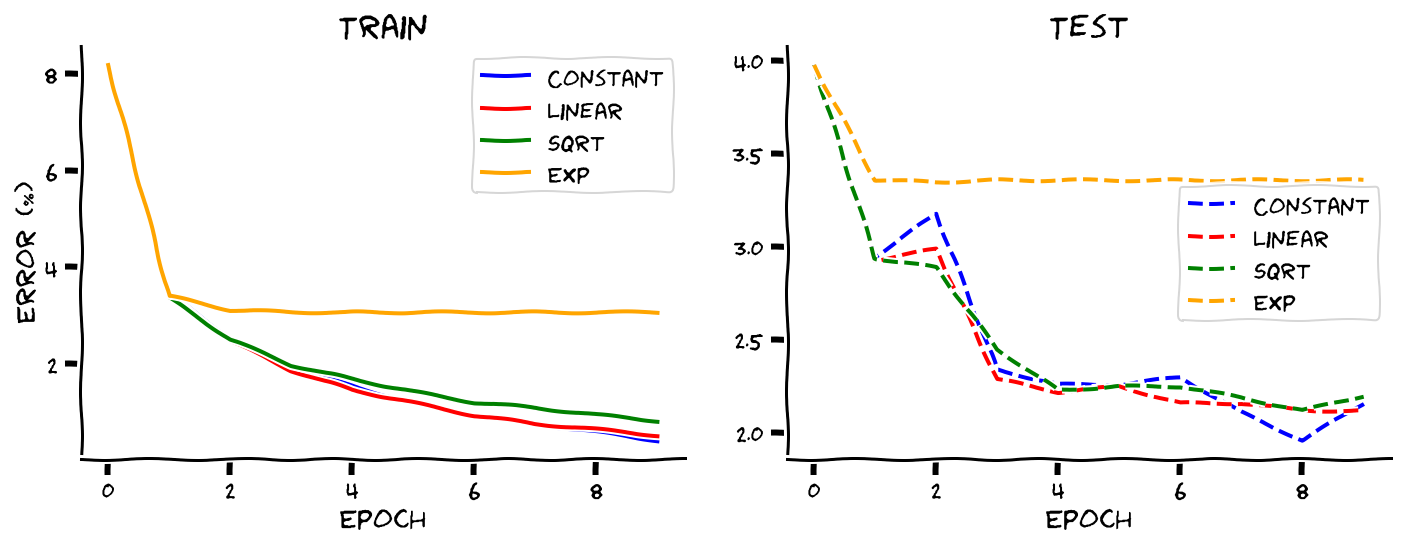

In [ ]:
# @markdown ### Plot (run me)
with plt.xkcd():
    fig, axs = plt.subplots(1, 2, figsize=(10,4))
    axs[0].plot(error_dict['trainconstant'], label='Constant', color='b')
    axs[1].plot(error_dict['testconstant'], label='Constant', color='b', linestyle='dashed')
    axs[0].plot(error_dict['trainlinear'], label='Linear', color='r')
    axs[1].plot(error_dict['testlinear'], label='Linear', color='r', linestyle='dashed')
    axs[0].plot(error_dict['trainsqrt'], label='Sqrt', color='g')
    axs[1].plot(error_dict['testsqrt'], label='Sqrt', color='g', linestyle='dashed')
    axs[0].plot(error_dict['trainexp'], label='Exp', color='orange')
    axs[1].plot(error_dict['testexp'], label='Exp', color='orange', linestyle='dashed')
    axs[0].set_title('Train')
    axs[1].set_title('Test')
    axs[0].set_ylabel('Error (%)')
    #plt.yscale('log')
    axs[0].set_xlabel('Epoch')
    axs[1].set_xlabel('Epoch')
    axs[0].legend()
    axs[1].legend()
    plt.show()

In [ ]:
#@markdown **Quiz Question 2** Which methods are good? Which are bad? Why?
method_performance = '' #@param {type:"string"}

---
# Section 2: Adaptive learning rate methods

Video available at https://youtube.com/watch?v=pR7CpHh3oNk


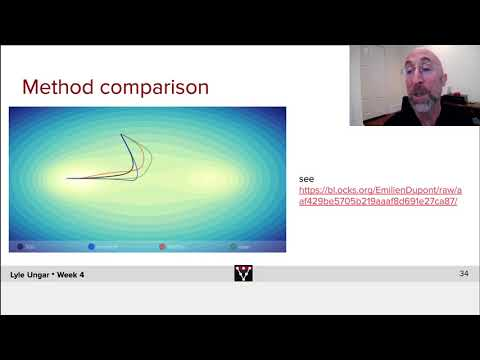

In [ ]:
#@title Video: Adaptative Gradient Descent

try: t1;
except NameError: t1=time.time()

video = YouTubeVideo(id="pR7CpHh3oNk", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)
video


In the standard SGD formulation, every weight in network is updated with the same learning rate (global $\eta$). Here, we adapt a learning rate for each weight individually, using information we get from their gradients.

## Section 2.1: Adagrad

Adagrad adapts the learning rate of each parameter, downweighting the learning rates for parameters that have changed a lot and upweighting the learning rates of parameters that have changed very little.

It uses a different learning rate for every parameter $w_j$ at every time step, $t$. (The time step here in practice is a minibatch, with everything averaged over that minibatch.) The update for every parameter $w_j$ at each time step (or epoch) $t$ then becomes

$$w_{t+1}=w_t- \frac{\eta}{\sqrt{v_{t+1}+\epsilon}} \nabla f(w_t)$$

where the equation holds for every feature $w_j$ separately. Thus, $\nabla f(w_{t})$ is the partial derivative of the objective function w.r.t. to the parameter $w_j$ at time step $t$ and the learning rate for each feature is scaleed using the sum of the gradients for that feature:

$$v_{t+1} = \sum^t_{\tau=1} \nabla f(w_{\tau})^2$$

Adagrad effectively selects low learning rates for parameters associated with frequently occurring features, and high learning rates for parameters associated with infrequent features. It is thus well-suited for dealing with sparse data.


In [ ]:
#@markdown **Quiz Question 3** Does Adagrad have a monotonically decreasing learning rate?
monotonically_decreasing = '' #@param {type:"string"}

#@markdown **Quiz Question 4** What problems can arise due to a monotonically decreasing learning rate? 
problems = '' #@param {type:"string"}




## Section 2.2: RMSprop

RMSprop seeks to reduce Adagrad's aggressive, monotonically decreasing learning rate. Instead of accumulating all past squared gradients, RMSprop restricts the window of accumulated past gradients to some fixed size. The sum of gradients is recursively defined as a decaying average of all past squared gradients.

$$w_{t+1}=w_t- \frac{\eta}{\sqrt{v_{t+1}+\epsilon}} \nabla f(w_t)$$
$$v_{t+1}=\alpha v_t+(1-\alpha)(\nabla f(w_t))^2$$

where 
*   $v$ is the 2nd moment estimate which depends (as a fraction $\alpha$ similarly to the Momentum term) on the previous average and the current gradient.
*   $\alpha$ is usually set to $0.9$, while a good default value for the learning rate $\eta$ is $0.001$.

We update $v$ to estimate this noisy quantity via an exponential moving average (which is a standard way of maintaining an average of a quantity that may change over time). We need to put larger weights on the newer values as they provide more information. One way to do that is down-weight old values exponentially. The values in the $v$ calculation that are very old are down-weighted at each step by an $\alpha$ constant, which varies between 0 and 1. This dampens the old values until they are no longer an important part of the exponential moving average.


### Adam

In addition to storing an exponentially decaying average of past squared gradients $v_t$ like RMSprop, Adam also keeps an exponentially decaying average of past gradients $m_t$, similar to momentum. Whereas momentum can be seen as a ball running down a slope, Adam behaves like a heavy ball with friction, which thus prefers flat minima in the error surface.

We compute the decaying averages of past gradients $m_t$ and past squared gradients $v_t$ respectively as follows,

$$m_{t+1}=\beta m_t+(1-\beta)\nabla f(w_t)$$
$$v_{t+1}=\alpha v_t+(1-\alpha)(\nabla f(w_t))^2$$

where
*   $m_t$ is the exponentially decaying average of the first moment (the mean) of the gradients,
*   $v_t$ is the exponentially decaying average of the second moment (the uncentered variance) of the gradients.

As always, each of these equations uses averages of the gradient (and squared gradient) over the observations in the minibatch $B_t$, and everything is computed separately for each feature (using vectorized code,  of couse!).

Since we initialize averages with zeros, the estimators are biased towards zero. To correct the bias,

$$\hat{m}_t=\frac{m_t}{1-\beta}$$
$$\hat{v}_t=\frac{v_t}{1-\alpha}$$

Finally, the Adam update rule is

$$w_{t+1}=w_t-\frac{\eta}{\sqrt{\hat{v}_t+\epsilon}} \hat{m}_t$$

where the default values for $\alpha$ and $\beta$ are $0.9$ and $0.999$.





[Interactive visualization](https://bl.ocks.org/EmilienDupont/raw/aaf429be5705b219aaaf8d691e27ca87/): click anywhere to see the different methods converge from that starting point

## Exercise 2: Learn and compare different adaptive learning rate optimizers

For SGD with fixed schedule, Adagrad, RMSprop, Adam, how do they differ on train and test error? Which one works the best?

We compare these optimizers by performing digit classification task in MNIST.

In [ ]:
def optimizer_eval(args):
    use_cuda = not args['no_cuda'] and torch.cuda.is_available()
    torch.manual_seed(args['seed'])
    device = torch.device('cuda' if use_cuda else 'cpu')

    train_kwargs = {'batch_size': args['batch_size']}
    test_kwargs = {'batch_size': args['test_batch_size']}
    if use_cuda:
        cuda_kwargs = {'num_workers': 1,
                       'pin_memory': True,
                       'shuffle': True}
        train_kwargs.update(cuda_kwargs)
        test_kwargs.update(cuda_kwargs)

    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])
    train_loader = torch.utils.data.DataLoader(datasets.MNIST('../data', train=True, download=True,
                       transform=transform),**train_kwargs)
    test_loader = torch.utils.data.DataLoader(datasets.MNIST('../data', train=False,
                       transform=transform), **test_kwargs)

    model = Net().to(device)
    if args['optimizer'] == 'sgd':
        optimizer = optim.SGD(model.parameters(), lr=args['lr'])
    elif args['optimizer'] == 'adagrad':
        optimizer = optim.Adagrad(model.parameters(), lr=args['lr'])
    elif args['optimizer'] == 'rmsprop':
        optimizer = optim.RMSprop(model.parameters(), lr=1e-3)
    elif args['optimizer'] == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=1e-3)

    train_list, test_list = [], []
    for epoch in range(1, args['epochs'] + 1):
        train_acc = train(args, model, device, train_loader, optimizer, epoch)
        train_list.append(100.-train_acc)
        test_acc = test(model, device, test_loader)
        test_list.append(100.-test_acc)

    return train_list, test_list 

The training takes over 20 mins. Time for a break again :) 

In [ ]:
# @markdown ### Train (run me)
# Training settings
args = {'batch_size': 64,
        'test_batch_size': 1000,
        'epochs': 10,
        'lr': 0.01,
        'momentum': 0.9,
        'net_type': 'Net',
        'anneal_type': 'linear',
        'optimizer': 'sgd',
        'no_cuda': False,
        'seed': 1,
        'log_interval': 100
        }

optimizer = ['sgd', 'adagrad', 'rmsprop', 'adam']
error_dict = {}

for i in range(len(optimizer)):
    args['optimizer'] = optimizer[i]
    train_error, test_error = optimizer_eval(args)
    error_dict['train' + str(optimizer[i])] = train_error
    error_dict['test' + str(optimizer[i])] = test_error

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.362731
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.959390
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.555897
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.409053
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.532658
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.311172
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.376333
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.369286
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.192239
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.606944

Test set: Average loss: 0.3207, Accuracy: 9104/10000 (91.0400%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.276807
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.618772
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.212266
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.382474
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.420732
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.169002
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.323872
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.192778
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.276

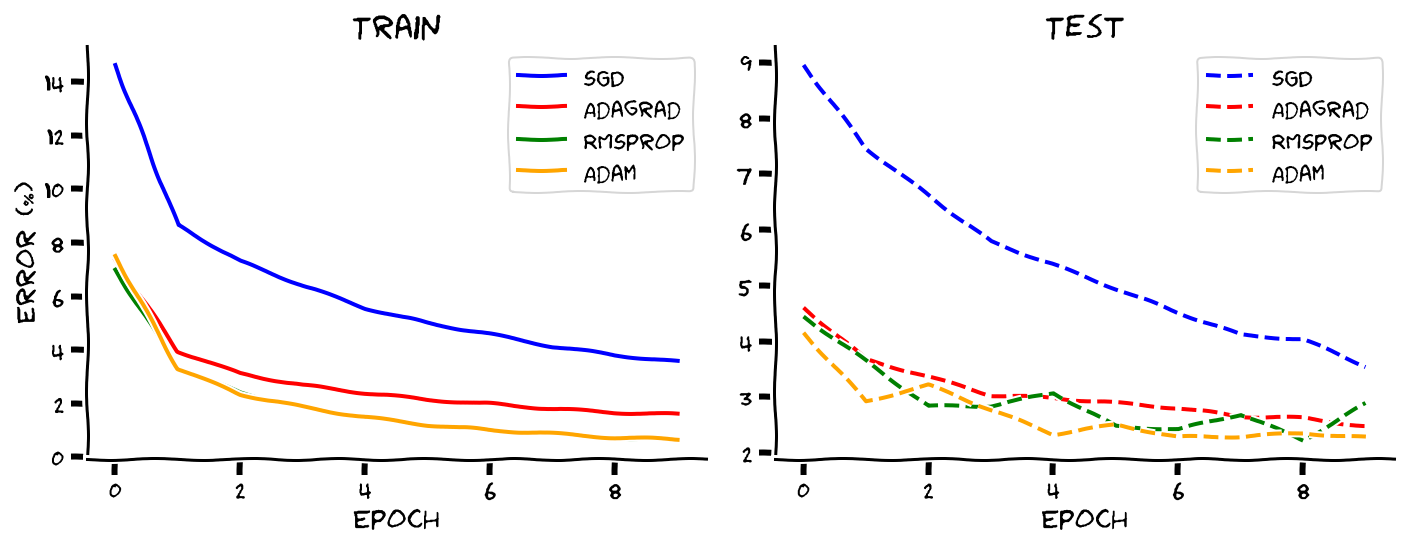

In [ ]:
# @markdown ### Plot (run me)
with plt.xkcd():
    fig, axs = plt.subplots(1, 2, figsize=(10,4))
    axs[0].plot(error_dict['trainsgd'], label='SGD', color='b')
    axs[1].plot(error_dict['testsgd'], label='SGD', color='b', linestyle='dashed')
    axs[0].plot(error_dict['trainadagrad'], label='Adagrad', color='r')
    axs[1].plot(error_dict['testadagrad'], label='Adagrad', color='r', linestyle='dashed')
    axs[0].plot(error_dict['trainrmsprop'], label='RMSprop', color='g')
    axs[1].plot(error_dict['testrmsprop'], label='RMSprop', color='g', linestyle='dashed')
    axs[0].plot(error_dict['trainadam'], label='Adam', color='orange')
    axs[1].plot(error_dict['testadam'], label='Adam', color='orange', linestyle='dashed')
    axs[0].set_title('Train')
    axs[1].set_title('Test')
    axs[0].set_ylabel('Error (%)')
    #plt.yscale('log')
    axs[0].set_xlabel('Epoch')
    axs[1].set_xlabel('Epoch')
    axs[0].legend()
    axs[1].legend()
    plt.show()

In [ ]:
#@markdown **Quiz Question 5 & 6**: How do the learning rate methods - fixed schedule, Adagrad, RMSprop, Adam differ on train and test error? What works best for each?
lr_best_train = '' #@param {type:"string"}
lr_best_test = '' #@param {type:"string"}


---
# Section 3:  Natural gradients

Video available at https://youtube.com/watch?v=QmM6_qBHuvM


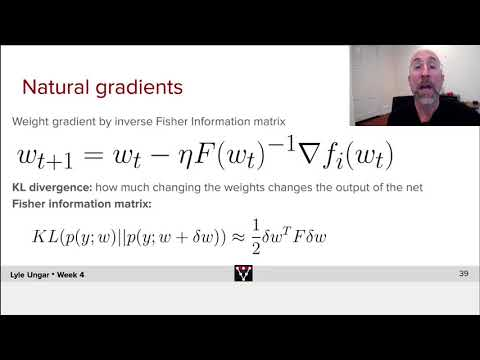

In [ ]:
#@title Video: Natural Gradient

try: t2;
except NameError: t2=time.time()

video = YouTubeVideo(id="QmM6_qBHuvM", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)
video

Neural nets, when trained on new data, tend to forget what they have already learned.  Natural gradients try to reduce this problem.

Instead of fixing the Euclidean distance each parameter moves in the parameter space, we can fix the distance in the distribution space of the target output. I.e., instead of changing the parameter vector to at  most move an epsilon distance, we constrain the output distribution of the model to be within an epsilon distance from the distribution on the previous step. We measure the distance between two distributions with Kullback-Leibler Divergence (KL) <insert link>. 
 The natural gradient update rule is

$$w_{t+1}=w_t-\eta F(w_t)^{-1}\nabla f_i(w_t)$$,

where $F(w_t)$ is the Fisher information matrix and 

$$KL(p(y;w)||p(y;w+\delta w))\approx \frac{1}{2} \delta w^T  F \delta w$$. 

The Fisher information measures the amount of information that an observable random variable $Y$ (here, the output of the neural net) carries about an unknown parameter (here, $w$) of a distribution that models $Y$. Formally, it is the variance of the score, or the expected value of the observed information. When there are $d$ parameters, then the Fisher information is a $d × d$ positive semidefinite matrix.

The natural gradient changes the input/output function the least possible amount as it moves down the gradient. It works great in theory but is hard to implement. If you’d like to learn more, [here](https://wiseodd.github.io/techblog/2018/03/14/natural-gradient/) is a nice formal description of natural gradients, which shows that “Fisher Information Matrix defines the local curvature in distribution space for which KL-divergence is the metric” and explains that the second moment, as calculated by Adam, approximates the Fisher Information Matrix.  I.e., Adam approximates natural gradients, but instead of inverting a (Fisher) matrix of dimension the number of weights x number of weights, it approximates that matrix by a diagonal matrix.


---
# Section 4:  Bias in ML: Amplification and class error imbalance

Video available at https://youtube.com/watch?v=GXlM9QVxE98


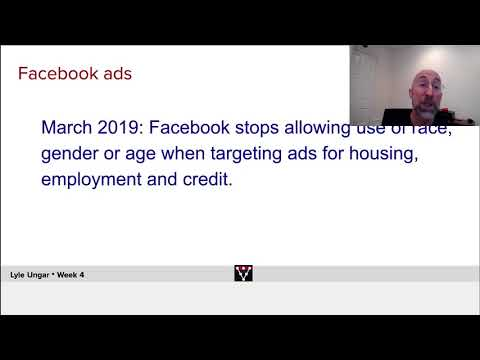

In [ ]:
#@title Video: Bias in ML

try: t3;
except NameError: t3=time.time()

video = YouTubeVideo(id="GXlM9QVxE98", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)
video

## Exercise 3: Class error imbalance

We introduce digit image samples with colorized background (instead of black in the original data) to the MNIST dataset. Then, the dataset consists of images with black background and red background in ratio 83% and 17% separately. We report the testing accuracy for the two types of images, along with the average accuracy.


In [ ]:
class colorMNIST(Dataset):

    COLOR_DICT = {
        'red': [1., 0., 0.],
        'blue': [0., 1., 0.],
        'green': [0., 0., 1.],
    }

    def __init__(self, train=True, color='red', ratio=0.2):
        self.train = train
        self.color = color
        self.ratio = ratio

        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Lambda(lambda x: x.repeat(3, 1, 1))
        ])

        self.data = datasets.MNIST('./datasets/mnist/MNIST', train=self.train, 
                                        download=True, transform=transform)
        self.data = self.colorize_dataset()

    def colorize_img(self, img):
        if self.color in self.COLOR_DICT.keys():
            color = self.COLOR_DICT[self.color]
        elif self.color == 'rand':
            color = torch.rand(3)
        else:
            raise ValueError('Invalid color.')

        zero_tensor = torch.zeros_like(img)
        zero_tensor[0, :, :] = color[0]
        zero_tensor[1, :, :] = color[1]
        zero_tensor[2, :, :] = color[2]

        return torch.where(img < 0.05, zero_tensor, img)

    def colorize_dataset(self):
        last_select_sample = int(len(self.data) * self.ratio)
        new_data = []
        for i in range(last_select_sample):
            img, label = self.data[i]
            new_img = self.colorize_img(img)
            new_data.append((new_img, label))

        new_data.extend(self.data)
        return new_data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img, label = self.data[index]
        return img, label

class colorNet(nn.Module):
    def __init__(self):
        super(colorNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)
        self.fc3 = nn.Linear(784, 128)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        #x = self.fc3(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

Check the original image and colorized image by running below cell.

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./datasets/mnist/MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ./datasets/mnist/MNIST/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./datasets/mnist/MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ./datasets/mnist/MNIST/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./datasets/mnist/MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ./datasets/mnist/MNIST/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./datasets/mnist/MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./datasets/mnist/MNIST/MNIST/raw



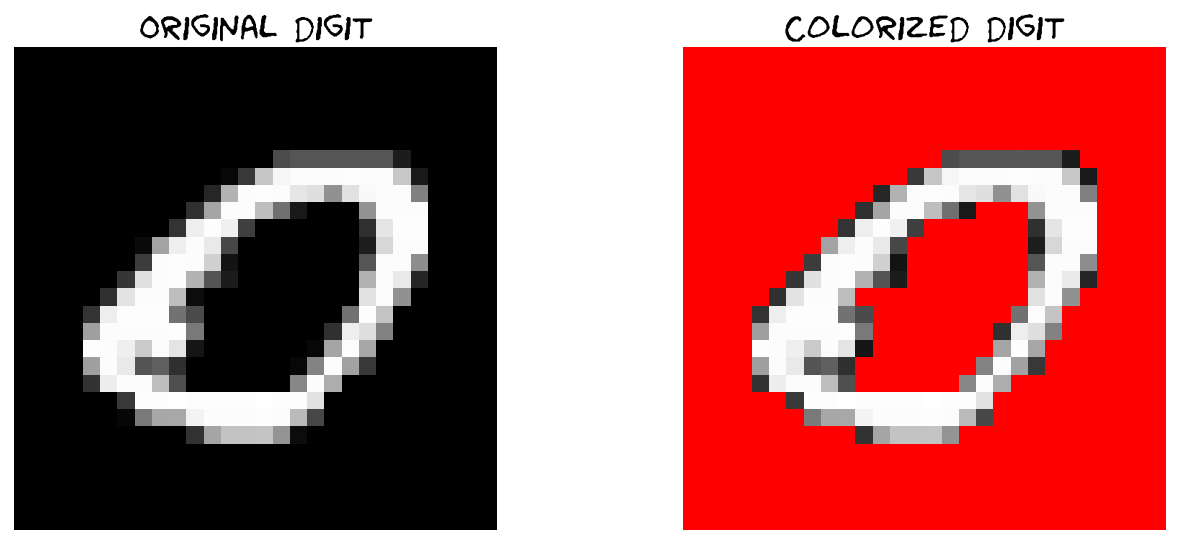

In [ ]:
data = colorMNIST().data
with plt.xkcd():
    fig, axs = plt.subplots(1, 2, figsize=(10,4))
    axs[0].imshow(data[int(len(data)*(2/12))+1][0].numpy().swapaxes(0,2))
    axs[1].imshow(data[1][0].numpy().swapaxes(0,2))
    axs[0].set_title('Original digit')
    axs[1].set_title('Colorized digit')
    axs[0].axis('off')
    axs[1].axis('off')
    plt.show()

In [ ]:
# @markdown ### Helper Functions (Run Me)
def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % args['log_interval'] == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    pred_list, target_list = [], []
    correct, raw_correct, color_correct = (0, 0, 0)
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            pred_list.append(pred)
            target_list.append(target.view_as(pred))
            #correct += pred.eq(target.view_as(pred)).sum().item()

    pred = torch.cat(pred_list, dim=0)
    target = torch.cat(target_list, dim=0)
    correct = pred.eq(target).sum().item()

    last_color_sample = int(len(test_loader.dataset)*(2/12))
    color_correct = pred[:last_color_sample].eq(target[:last_color_sample]).sum().item()
    raw_correct = pred[last_color_sample:].eq(target[last_color_sample:]).sum().item()
    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Avg Accuracy: {}/{} ({:.4f}%), Raw Accuracy: {:.4f}%, Color Accuracy: {:.4f}%\n'.format(
        test_loss, correct, len(test_loader.dataset), 100. * correct / len(test_loader.dataset), 100. * raw_correct / (len(test_loader.dataset)-last_color_sample),
        100. * color_correct / last_color_sample))
    return 100. * correct / len(test_loader.dataset), 100. * raw_correct / (len(test_loader.dataset)-last_color_sample), 100. * color_correct / last_color_sample
    
def main(args):
    use_cuda = not args['no_cuda'] and torch.cuda.is_available()
    torch.manual_seed(args['seed'])
    device = torch.device('cuda' if use_cuda else 'cpu')

    train_kwargs = {'batch_size': args['batch_size']}
    test_kwargs = {'batch_size': args['test_batch_size']}
    if use_cuda:
        cuda_kwargs = {'num_workers': 1,
                       'pin_memory': True}
        train_kwargs.update(cuda_kwargs)
        test_kwargs.update(cuda_kwargs)

    train_loader = torch.utils.data.DataLoader(colorMNIST(train=True), shuffle=True, **train_kwargs)
    test_loader = torch.utils.data.DataLoader(colorMNIST(train=False), shuffle=False, **test_kwargs)

    model = colorNet().to(device)
    optimizer = optim.SGD(model.parameters(), lr=args['lr'], momentum=args['momentum'])

    acc_list, raw_list, color_list = [], [], []
    start_time = time.time()
    for epoch in range(1, args['epochs'] + 1):
        train(args, model, device, train_loader, optimizer, epoch)
        #time_list.append(time.time()-start_time)
        acc, raw, color = test(model, device, test_loader)
        acc_list.append(acc)
        raw_list.append(raw)
        color_list.append(color)

    return acc_list, raw_list, color_list

In [ ]:
# @markdown ### Train (run me)
# Training settings
args = {'batch_size': 64,
        'test_batch_size': 1000,
        'epochs': 10,
        'lr': 0.01,
        'momentum': 0.9,
        'no_cuda': False,
        'seed': 1,
        'log_interval': 100
        }

acc_list, raw_list, color_list = main(args)

Train Epoch: 1 [0/72000 (0%)]	Loss: 2.292537
Train Epoch: 1 [6400/72000 (9%)]	Loss: 0.580204
Train Epoch: 1 [12800/72000 (18%)]	Loss: 0.413052
Train Epoch: 1 [19200/72000 (27%)]	Loss: 0.240213
Train Epoch: 1 [25600/72000 (36%)]	Loss: 0.358204
Train Epoch: 1 [32000/72000 (44%)]	Loss: 0.302859
Train Epoch: 1 [38400/72000 (53%)]	Loss: 0.191772
Train Epoch: 1 [44800/72000 (62%)]	Loss: 0.344209
Train Epoch: 1 [51200/72000 (71%)]	Loss: 0.263086
Train Epoch: 1 [57600/72000 (80%)]	Loss: 0.063253
Train Epoch: 1 [64000/72000 (89%)]	Loss: 0.124210
Train Epoch: 1 [70400/72000 (98%)]	Loss: 0.147731

Test set: Average loss: 0.0809, Avg Accuracy: 11693/12000 (97.4417%), Raw Accuracy: 97.6300%, Color Accuracy: 96.5000%

Train Epoch: 2 [0/72000 (0%)]	Loss: 0.046424
Train Epoch: 2 [6400/72000 (9%)]	Loss: 0.100947
Train Epoch: 2 [12800/72000 (18%)]	Loss: 0.133210
Train Epoch: 2 [19200/72000 (27%)]	Loss: 0.154250
Train Epoch: 2 [25600/72000 (36%)]	Loss: 0.076301
Train Epoch: 2 [32000/72000 (44%)]	Loss: 0.

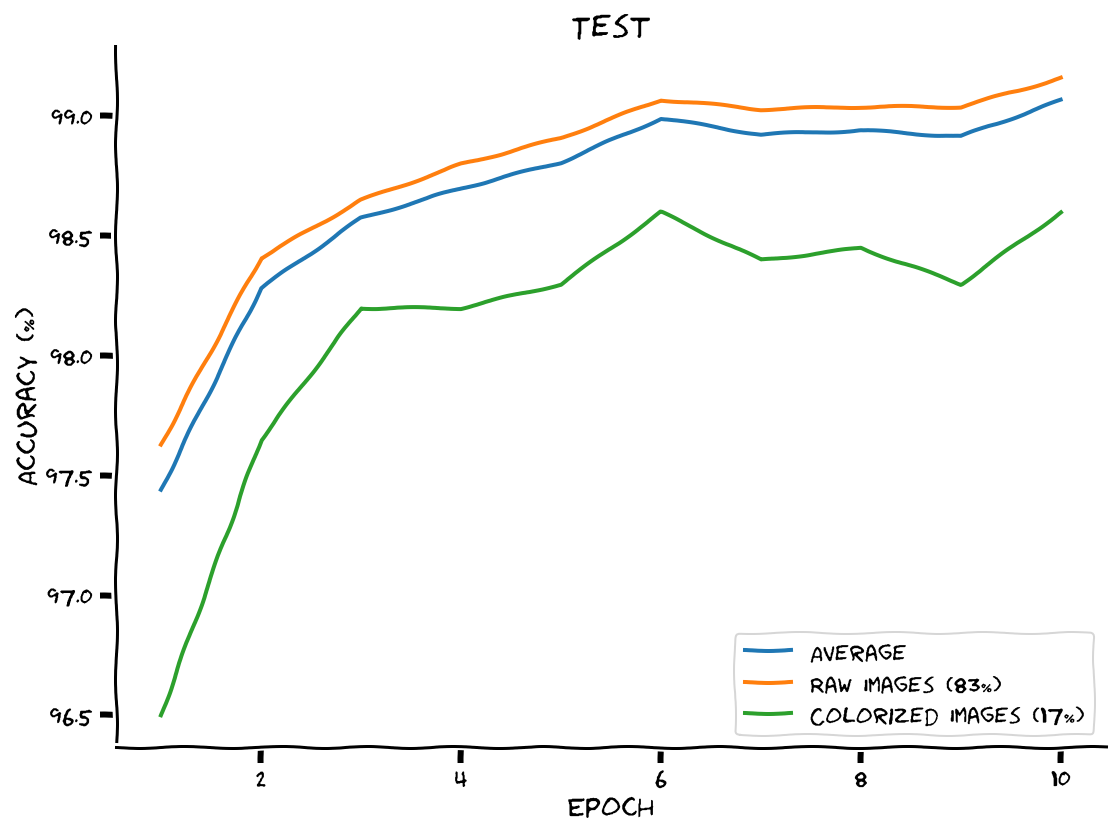

In [ ]:
# @markdown ### Plot (run me)
with plt.xkcd():
    plt.plot(np.arange(10)+1, acc_list, label='Average')
    plt.plot(np.arange(10)+1, raw_list, label='Raw Images (83%)')
    plt.plot(np.arange(10)+1, color_list, label='Colorized Images (17%)')
    plt.title('Test')
    plt.ylabel('Accuracy (%)')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

**Quiz Question 7:** Which class (black background vs. red background) has lower accuracy? Why does it have lower accuracy? 


In [ ]:
lower_acc = '' #@param {type:"string"}

## Exercise 4: Amplification

We again use zeros and ones from MNIST dataset for binary classification. The class sample ratio is 83% : 17% for 0 and 1 respectively. When testing, we apply a Gaussian blur filter and add Guassian noise to the images from both class. We report the testing accuracy for the two class of images, along with the average accuracy.


In [ ]:
class GaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean

class binaryMNIST(Dataset):

    def __init__(self, train=True, size=(5000, 900), ratio=0.2):
        self.train = train
        self.size= size
        self.ratio = ratio

        if self.train:
            transform=transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,))
            ])

            self.data = datasets.MNIST('./datasets/mnist/MNIST', train=True, 
                                        download=True, transform=transform)
            mask = []
            for i in range(2):
                idxes = np.where(self.data.targets == i)[0]
                if i == 0:
                    mask.append(idxes[:self.size[0]])
                else:
                    mask.append(idxes[:int(self.size[0]*self.ratio)])
        else:
            transform=transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,)),
                transforms.GaussianBlur(3, sigma=(0.1, 2.0)),
                GaussianNoise(0., 0.1)
            ])

            self.data = datasets.MNIST('./datasets/mnist/MNIST', train=False, 
                                        download=True, transform=transform)
            mask = []
            for i in range(2):
                idxes = np.where(self.data.targets == i)[0]
                if i == 0:
                    mask.append(idxes[:self.size[1]])
                else:
                    mask.append(idxes[:int(self.size[1]*self.ratio)])
  
        
        masks = np.concatenate(mask, axis=None)
        self.images, self.labels = self.data.data[masks], self.data.targets[masks]
        
    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img, label = self.images[index].float(), self.labels[index].long()
        return img, label

class binaryNet(nn.Module):
    def __init__(self):
        super(binaryNet, self).__init__()
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 2)
        self.fc3 = nn.Linear(784, 128)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

Check the training image and testing image (Gaussian filter and noises are applied) by running below cell.

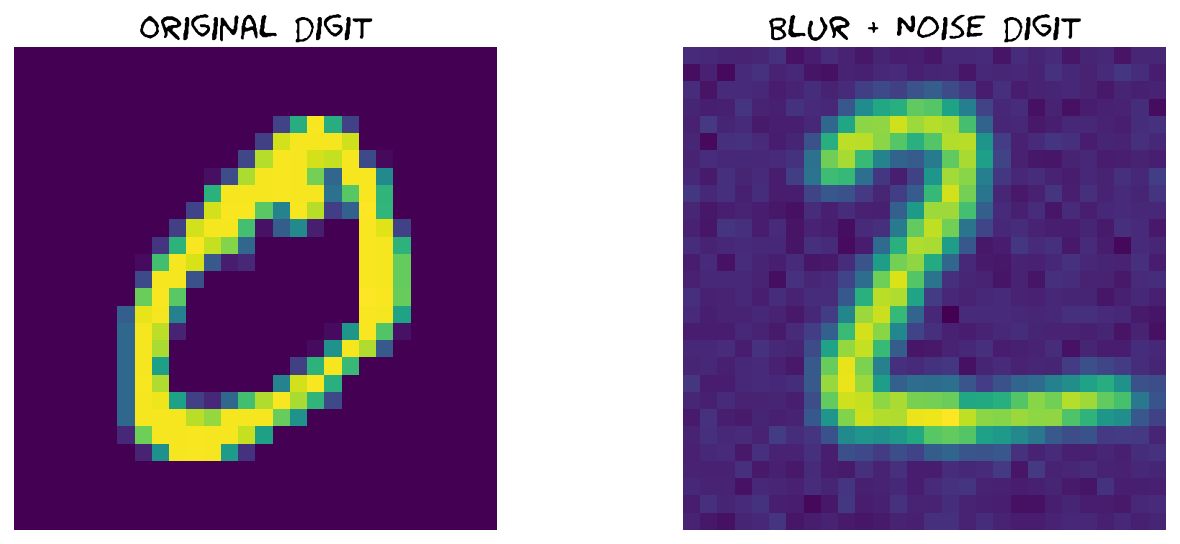

In [ ]:
train_data = binaryMNIST(train=True).data
test_data = binaryMNIST(train=False).data
with plt.xkcd():
    fig, axs = plt.subplots(1, 2, figsize=(10,4))
    axs[0].imshow(np.squeeze(train_data[1][0].numpy(), axis=0))
    axs[1].imshow(np.squeeze(test_data[1][0].numpy(), axis=0))
    axs[0].set_title('Original digit')
    axs[1].set_title('Blur + Noise digit')
    axs[0].axis('off')
    axs[1].axis('off')
    plt.show()

In [ ]:
# @markdown ### Helper Functions (Run Me)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    pred_list, target_list = [], []
    correct, zero_correct, one_correct = (0, 0, 0)
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            pred_list.append(pred)
            target_list.append(target.view_as(pred))
            #correct += pred.eq(target.view_as(pred)).sum().item()

    pred = torch.cat(pred_list, dim=0)
    target = torch.cat(target_list, dim=0)
    correct = pred.eq(target).sum().item()

    #last_color_sample = int(len(test_loader.dataset)*(2/12))
    zero_correct = pred[target==0].eq(target[target==0]).sum().item()
    one_correct = pred[target==1].eq(target[target==1]).sum().item()
    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Avg Accuracy: {}/{} ({:.4f}%), Zero Accuracy: {:.4f}%, One Accuracy: {:.4f}%\n'.format(
        test_loss, correct, len(test_loader.dataset), 100. * correct / len(test_loader.dataset), 100. * zero_correct / len(target==0),
        100. * one_correct / len(target==1)))
    return 100. * correct / len(test_loader.dataset), 100. * zero_correct / len(target==0), 100. * one_correct / len(target==1)
    
def main(args):
    use_cuda = not args['no_cuda'] and torch.cuda.is_available()
    torch.manual_seed(args['seed'])
    device = torch.device('cuda' if use_cuda else 'cpu')

    train_kwargs = {'batch_size': args['batch_size']}
    test_kwargs = {'batch_size': args['test_batch_size']}
    if use_cuda:
        cuda_kwargs = {'num_workers': 1,
                       'pin_memory': True}
        train_kwargs.update(cuda_kwargs)
        test_kwargs.update(cuda_kwargs)

    train_loader = torch.utils.data.DataLoader(binaryMNIST(train=True), shuffle=True, **train_kwargs)
    test_loader = torch.utils.data.DataLoader(binaryMNIST(train=False), shuffle=False, **test_kwargs)

    model = binaryNet().to(device)
    optimizer = optim.SGD(model.parameters(), lr=args['lr'], momentum=args['momentum'])

    acc_list, one_list, zero_list = [], [], []
    start_time = time.time()
    for epoch in range(1, args['epochs'] + 1):
        train(args, model, device, train_loader, optimizer, epoch)
        #time_list.append(time.time()-start_time)
        acc, zero, one = test(model, device, test_loader)
        acc_list.append(acc)
        zero_list.append(zero)
        one_list.append(one)
        
    return acc_list, zero_list, one_list

In [ ]:
# @markdown ### Train (run me)
# Training settings
args = {'batch_size': 64,
        'test_batch_size': 1000,
        'epochs': 10,
        'lr': 0.01,
        'momentum': 0.9,
        'no_cuda': False,
        'seed': 1,
        'log_interval': 100
        }

acc_list, zero_list, one_list = main(args)

Train Epoch: 1 [0/6000 (0%)]	Loss: 19.003281

Test set: Average loss: 0.1872, Avg Accuracy: 900/1080 (83.3333%), Zero Accuracy: 83.3333%, One Accuracy: 0.0000%

Train Epoch: 2 [0/6000 (0%)]	Loss: 0.392334

Test set: Average loss: 0.3892, Avg Accuracy: 900/1080 (83.3333%), Zero Accuracy: 83.3333%, One Accuracy: 0.0000%

Train Epoch: 3 [0/6000 (0%)]	Loss: 0.357585

Test set: Average loss: 0.3902, Avg Accuracy: 900/1080 (83.3333%), Zero Accuracy: 83.3333%, One Accuracy: 0.0000%

Train Epoch: 4 [0/6000 (0%)]	Loss: 0.526498

Test set: Average loss: 0.3904, Avg Accuracy: 900/1080 (83.3333%), Zero Accuracy: 83.3333%, One Accuracy: 0.0000%

Train Epoch: 5 [0/6000 (0%)]	Loss: 0.446106

Test set: Average loss: 0.3908, Avg Accuracy: 900/1080 (83.3333%), Zero Accuracy: 83.3333%, One Accuracy: 0.0000%

Train Epoch: 6 [0/6000 (0%)]	Loss: 0.398096

Test set: Average loss: 0.3901, Avg Accuracy: 900/1080 (83.3333%), Zero Accuracy: 83.3333%, One Accuracy: 0.0000%

Train Epoch: 7 [0/6000 (0%)]	Loss: 0.46

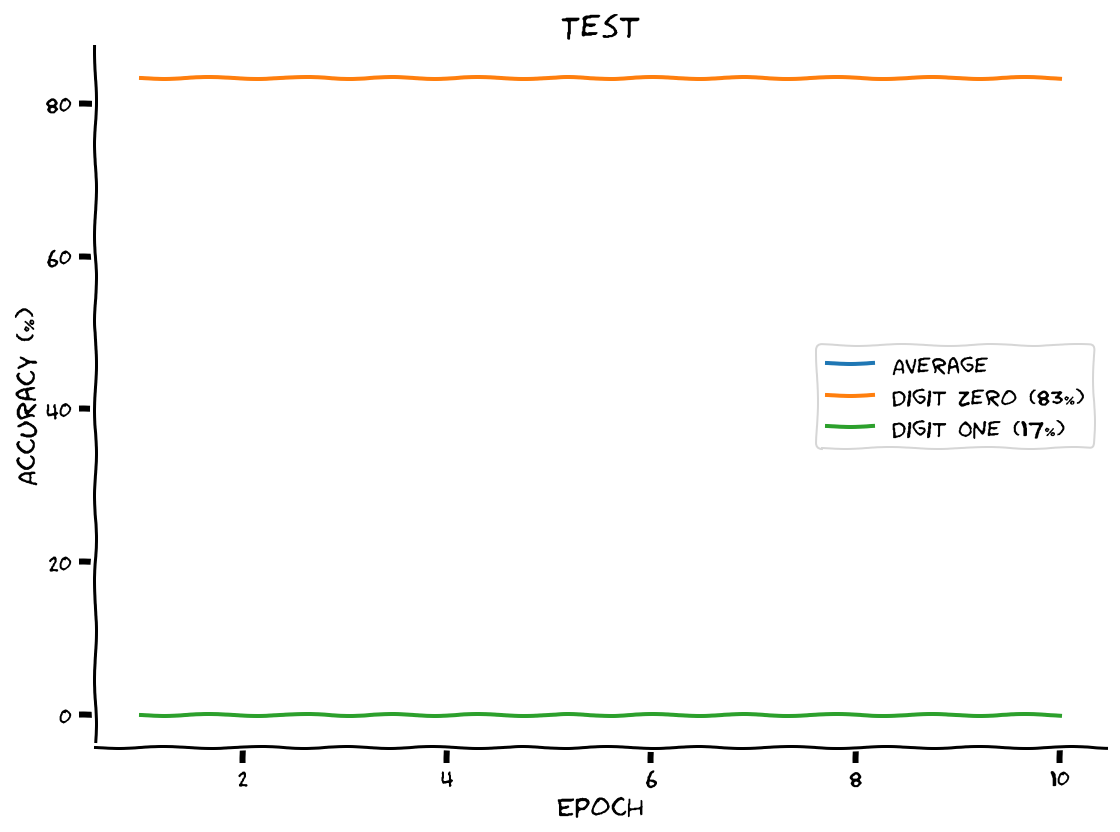

In [ ]:
# @markdown ### Plot (run me)
with plt.xkcd():
    plt.plot(np.arange(10)+1, acc_list, label='Average')
    plt.plot(np.arange(10)+1, zero_list, label='Digit Zero (83%)')
    plt.plot(np.arange(10)+1, one_list, label='Digit One (17%)')
    plt.title('Test')
    plt.ylabel('Accuracy (%)')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

In [ ]:
#@markdown **Quiz Question 8**: What is the ratio of predicted majority class 0's to rarer 1's on the blurred images? Why does this outcome occur? What real world consequences might this mathematical property have?
pred_majority = "" #@param {type:"string"}


---
# Quiz

As you might have seen, the quiz questions are now dispersed throughout the notebook. This was requested by a few of you and we hope it makes it easier to answer questions as you go :) 

---
# Wrap up

## Submit responses

In [ ]:
#@markdown #Run Cell to Show Airtable Form
#@markdown ##**Confirm your answers and then click "Submit"**

import time
import numpy as np
from IPython.display import IFrame

def prefill_form(src, fields: dict):
  '''
  src: the original src url to embed the form
  fields: a dictionary of field:value pairs,
  e.g. {"pennkey": my_pennkey, "location": my_location}
  '''
  prefills = "&".join(["prefill_%s=%s"%(key, fields[key]) for key in fields])
  src = src + prefills
  src = "+".join(src.split(" "))
  return src


#autofill time if it is not present
try: t0;
except NameError: t0 = time.time()
try: t1;
except NameError: t1 = time.time()

#autofill fields if they are not present
#a missing pennkey and pod will result in an Airtable warning
#which is easily fixed user-side.
try: my_pennkey;
except NameError: my_pennkey = ""
try: my_pod;
except NameError: my_pod = ""
try: annealing_difference;
except NameError: annealing_difference = ""
try: annealing_answer;
except NameError: annealing_answer = ""
try: method_performance;
except NameError: method_performance = ""
try: monotonically_decreasing;
except NameError: monotonically_decreasing = "Select"
try: problems;
except NameError: problems = ""
try: lr_best_train;
except NameError: lr_best_train = ""
try: lr_best_test;
except NameError: lr_best_test = ""
try: lower_acc;
except NameError: lower_acc = ""
try: pred_majority;
except NameError: pred_majority = ""

times = [(t-t0) for t in [t1]]

fields = {
    "pennkey": my_pennkey,
    "pod": my_pod,
    "email": my_email,
	  "annealing_difference": annealing_difference,
    "annealing_answer": annealing_answer,
    "method_performance": method_performance,
    "monotonically_decreasing":monotonically_decreasing,
    "problems": problems,
    "lr_best_train": lr_best_train,
    "lr_best_test": lr_best_test,
    "lower_acc": lower_acc,
    "pred_majority": pred_majority,
    "cumulative_times": times
}

src = "https://airtable.com/embed/shruKq3EOz0eKxq7w?"

#now instead of the original source url, we do: src = prefill_form(src, fields)
display(IFrame(src = prefill_form(src, fields), width = 800, height = 400))


# Feedback

*   How could this session have been better?
*   How happy are you in your group?
*   How do you feel right now?


In [ ]:
# @title Feedback form
display(IFrame(src="https://airtable.com/embed/shr1TzujOOOY21kFQ", width = 800, height = 400))